## Notebook 2: Regression and predictive modeling of Rossmann stores daily sales using LSTM model

**1. Prepare Problem**

In [1]:
# a) Load libraries

import pandas as pd
from pandas import set_option
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from pickle import dump

In [2]:
# b) Load dataset
# Load and view each file in the dataset
raw_train = pd.read_csv('train.csv', header=0)
raw_train = raw_train.reset_index()
print(raw_train.shape)
print(raw_train.head(10))
print(raw_train.dtypes)

raw_test = pd.read_csv('test.csv', header=0)
print(raw_test.shape)
print(raw_test.head(10))
print(raw_test.dtypes)

store = pd.read_csv('store.csv', header=0)
print(store.shape)
print(store.head(10))
print(store.dtypes)

(1017209, 10)
   index  Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0      0      1          5  2015-07-31   5263        555     1      1   
1      1      2          5  2015-07-31   6064        625     1      1   
2      2      3          5  2015-07-31   8314        821     1      1   
3      3      4          5  2015-07-31  13995       1498     1      1   
4      4      5          5  2015-07-31   4822        559     1      1   
5      5      6          5  2015-07-31   5651        589     1      1   
6      6      7          5  2015-07-31  15344       1414     1      1   
7      7      8          5  2015-07-31   8492        833     1      1   
8      8      9          5  2015-07-31   8565        687     1      1   
9      9     10          5  2015-07-31   7185        681     1      1   

  StateHoliday  SchoolHoliday  
0            0              1  
1            0              1  
2            0              1  
3            0              1  
4            0        

C:\Users\huyha\AppData\Local\Temp\ipykernel_13652\2567690122.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_train = pd.read_csv('train.csv', header=0)


The test set doesn't have Sales and Customers features so we can't use them for validation purposes. The file Store.csv includes useful data that can aid the training process so we merge it with Train.csv data on the same column named "Store".

In [3]:
# Merge the store data to train dataset
data = raw_train.merge(store,on=["Store"], how="inner")
print(data.shape)
print(data.dtypes)

(1017209, 19)
index                          int64
Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

           index      Store  DayOfWeek      Sales  Customers       Open  \
count  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06  1.017e+06   
mean   5.086e+05  5.584e+02  3.998e+00  5.774e+03  6.331e+02  8.301e-01   
std    2.936e+05  3.219e+02  1.997e+00  3.850e+03  4.644e+02  3.755e-01   
min    0.000e+00  1.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00   
25%    2.543e+05  2.800e+02  2.000e+00  3.727e+03  4.050e+02  1.000e+00   
50%    5.086e+05  5.580e+02  4.000e+00  5.744e+03  6.090e+02  1.000e+00   
75%    7.629e+05  8.380e+02  6.000e+00  7.856e+03  8.370e+02  1.000e+00   
max    1.017e+06  1.115e+03  7.000e+00  4.155e+04  7.388e+03  1.000e+00   

           Promo  SchoolHoliday  CompetitionDistance  \
count  1.017e+06      1.017e+06            1.015e+06   
mean   3.815e-01      1.786e-01            5.430e+03   
std    4.858e-01      3.831e-01            7.715e+03   
min    0.000e+00      0.000e+00            2.000e+01   
25%    0.000e+00      0.000e+00            7

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index(['Date', 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')

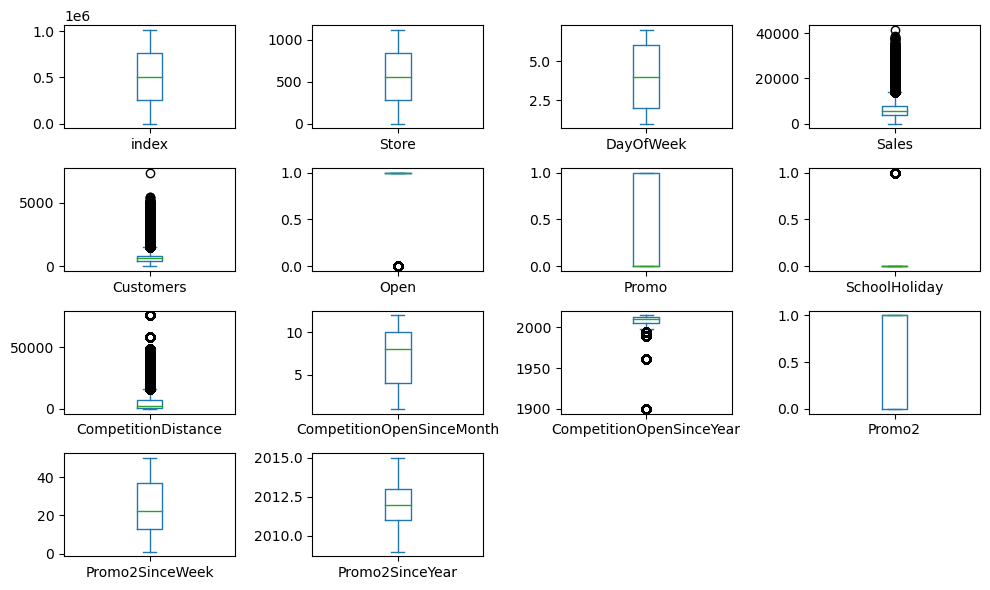

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)
plt.show()

We can see the data skewed to the low values in Sales, Customers, and CompetitionDistance. The Sales and Customer data exhibit a wide range of distribution.

                               index      Store  DayOfWeek  Sales  Customers  \
index                      1.000e+00  2.166e-04 -2.023e-04 -0.042     -0.013   
Store                      2.166e-04  1.000e+00 -8.484e-06  0.005      0.024   
DayOfWeek                 -2.023e-04 -8.484e-06  1.000e+00 -0.462     -0.386   
Sales                     -4.191e-02  5.126e-03 -4.621e-01  1.000      0.895   
Customers                 -1.287e-02  2.432e-02 -3.864e-01  0.895      1.000   
Open                       7.957e-05 -4.674e-05 -5.290e-01  0.678      0.617   
Promo                     -1.678e-02  5.786e-05 -3.929e-01  0.452      0.316   
SchoolHoliday             -2.068e-03  6.407e-04 -2.054e-01  0.085      0.072   
CompetitionDistance       -2.096e-03 -2.641e-02 -2.461e-05 -0.019     -0.103   
CompetitionOpenSinceMonth  3.050e-04 -5.075e-02  5.882e-06 -0.028     -0.031   
CompetitionOpenSinceYear  -2.269e-03 -4.592e-03 -2.537e-05  0.013      0.009   
Promo2                     1.465e-02  8.

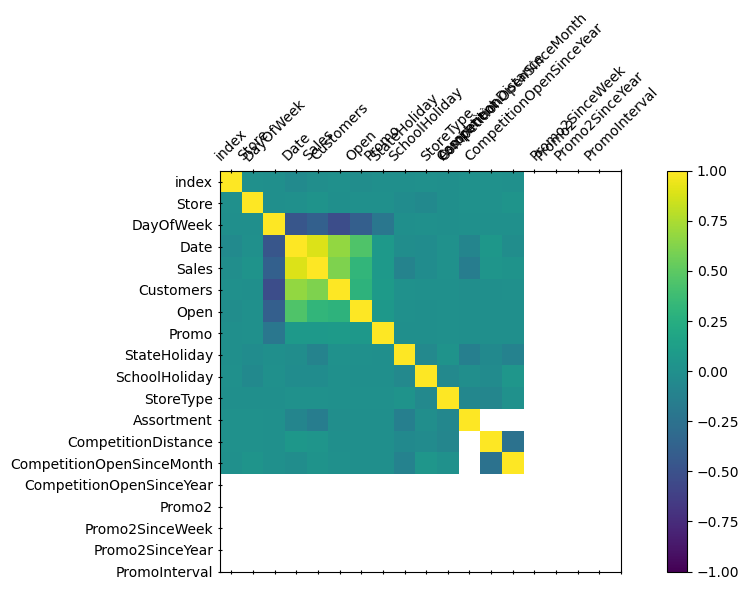

In [7]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,19))
sub_fig.set_yticks(np.arange(0,19))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

The correlation matrix indicates sales data is sensitive to the Date and Customers features.

**3. Prepare Data**

In [8]:
# a) Data Cleaning
# Extract Date feature into subcategories

data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.week
data["Day"] = data["Date"].dt.day

# Create 2 new features representing weekend and promotion
data["weekend"] = np.where(data["DayOfWeek"].isin([6, 7]), "Weekend","Weekday")
data["promotion"] = np.where(data["Month"].isin([7, 8, 11, 12]), "Pro_Month", "Reg_Month")

y_temp = data['Sales']

C:\Users\huyha\AppData\Local\Temp\ipykernel_13652\1081422598.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["Week"] = data["Date"].dt.week


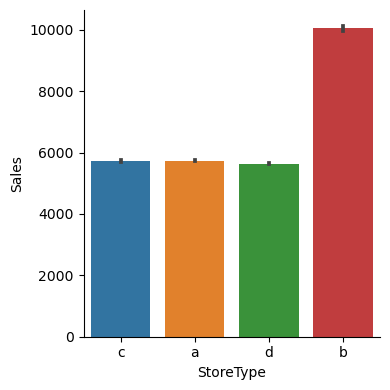

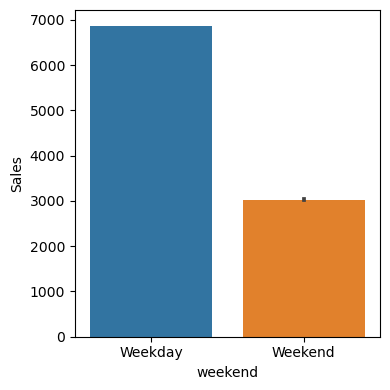

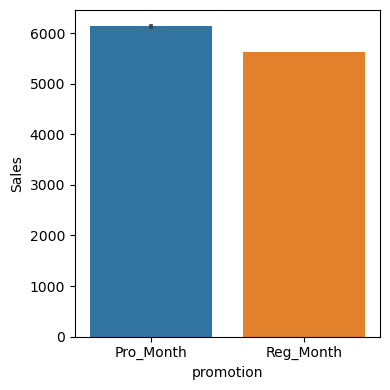

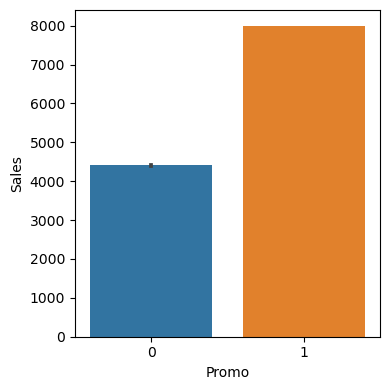

In [9]:
# Visualize Sales vs. store type 
fig1, ax1 = plt.subplots(figsize=(4,4))
sn.barplot(x=data['StoreType'], y=y_temp, data=data, ax=ax1)

# Visualize Sales vs. weekend
fig2, ax2 = plt.subplots(figsize=(4, 4))
sn.barplot(x=data['weekend'], y=y_temp, data=data, ax=ax2)

# Visualize Sales vs. promotion months 
fig3, ax3 = plt.subplots(figsize=(4, 4))
sn.barplot(x=data['promotion'], y=y_temp, data=data, ax=ax3)

# Visualize Sales vs. Promo 
fig4, ax4 = plt.subplots(figsize=(4,4))
sn.barplot(x=data['Promo'], y=y_temp, data=data, ax=ax4)

sn.despine(fig1, fig2, fig3, fig4)

An interesting observation from the Sales vs Weekend chart is that sales on weekdays are generally higher than on weekends (Saturday and Sunday). Sales also appear to be better during the promotion period.

It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [10]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Sales']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [11]:
# summarize the number of unique values in each column
print(data.nunique())

# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

index                        996865
Store                          1094
DayOfWeek                         7
Date                            942
Sales                         21734
Customers                      4086
Open                              2
Promo                             2
StateHoliday                      5
SchoolHoliday                     2
StoreType                         4
Assortment                        3
CompetitionDistance             641
CompetitionOpenSinceMonth        12
CompetitionOpenSinceYear         20
Promo2                            2
Promo2SinceWeek                  24
Promo2SinceYear                   7
PromoInterval                     3
Year                              3
Month                            12
Week                             52
Day                              31
weekend                           2
promotion                         2
dtype: int64
index                             0
Store                             0
DayOfWeek      

In [12]:
# Impute missing values with 'mode' values in this important variable (CompetitionDistance)
data["CompetitionDistance"]=data["CompetitionDistance"].fillna(data["CompetitionDistance"].mode()[0])

In [13]:
# Convert strings into categorial classes
mapping1 = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
data['StoreType'] = data['StoreType'].replace(mapping1)

mapping2 = {'a': 1, 'b': 2, 'c': 3}
data['Assortment'] = data['Assortment'].replace(mapping2)

mapping3 = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
data['StateHoliday'] = data['StateHoliday'].replace(mapping3)

# Convert strings into categorial classes
data = pd.get_dummies(data = data, columns = ["weekend", "promotion"])
print(data.shape)

(1017209, 27)


In [14]:
# One hot encoding these categorial features
ohe = OneHotEncoder(categories='auto')
ohe.fit_transform(data[['StoreType', 'Assortment', 'StateHoliday']]).toarray()
print(data.shape)

(1017209, 27)


In this step, the data is split into train, test, and validation sets using time-based split method. This method is particularly useful when there is a clear temporal component to the data, such as sales data where you want to evaluate the model's ability to make predictions on future data.

In [15]:
# b) Split the data into training, test, and validation sets

train = data[:int(len(data) * 0.7)]
test = data[int(len(data) * 0.7):int(len(data) * 0.9)]
validation = data[int(len(data) * 0.9):]
print(train.shape, test.shape, validation.shape)

X_train = train.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
X_test = test.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
X_val = validation.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
y_val = validation['Sales']

(712046, 27) (203442, 27) (101721, 27)


Data needs to be stationary in LSTM models because a key assumption in time series analysis and modeling is that the underlying process generating the data is stationary, meaning that its statistical properties (such as mean and variance) remain constant over time. Stationary data also helps in removing trends and seasonality from the time series,  which are typically not of interest when modeling and making predictions.

In [16]:
y_train_ori = train['Sales']
y_test_ori = test['Sales']

# There are a number of methods to make data stationary in time: difference, log/squared root transform, 
# decomposition, and ARIMA. Here I use the squared root transformation considering broad range of data.
train.loc[:, 'Sales_sqrt'] = np.sqrt(y_train_ori)
test.loc[:, 'Sales_sqrt']  = np.sqrt(y_test_ori)

# Now we can use Sales_diff as a new target for training and validation
y_train = train['Sales_sqrt']
y_test = test['Sales_sqrt']

C:\Users\huyha\AppData\Local\Temp\ipykernel_13652\3971955495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'Sales_sqrt'] = np.sqrt(y_train_ori)
C:\Users\huyha\AppData\Local\Temp\ipykernel_13652\3971955495.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Sales_sqrt']  = np.sqrt(y_test_ori)


In [17]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)
X_val = DataFrame(X_val)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(712046, 19) (203442, 19)
(712046,) (203442,)


**4. Evaluate Algorithms**

In [18]:
# Define baseline mean_absolute_error of y_test and y in the data set
y_mean = np.mean(y_temp)
y_mean = np.array([y_mean]*len(y_test))
mae_ori = mean_absolute_error(y_test**2, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  2822.964400997831


In [19]:
# Function to convert an array into a input tensor for LSTM. Note that lookback 
def create_tensor(data, lookback=1):
    X = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
    return np.array(X)

In [20]:
# Convert the training, testing, and validation arrays into input tensors [samples, timesteps, features]
# for LSTM model. Here I select 7 days lookback to capture changes in weekly basis.

lookback = 7
X_train = create_tensor(X_train, lookback)
X_test = create_tensor(X_test, lookback)
X_val = create_tensor(X_val, lookback)
y_train = y_train[lookback:]
y_test = y_test[lookback:]
y_val = y_val[lookback:]

In [21]:
# build the LSTM model
# This kind of neural network model is susceptible to overfitting, so incorporating BatchNormalization
# and Dropout layers can aid in stabilizing and enhancing the model's performance.

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization()),
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(BatchNormalization()),
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

In [22]:
# Define a callback for early stopping if the validation loss does not improve for 20 consecutive 
# epochs (patience=20).
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [23]:
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)

Epoch 1/50
5563/5563 - 106s - loss: 0.7235 - val_loss: 0.3084 - 106s/epoch - 19ms/step
Epoch 2/50
5563/5563 - 94s - loss: 0.2653 - val_loss: 0.1873 - 94s/epoch - 17ms/step
Epoch 3/50
5563/5563 - 108s - loss: 0.2003 - val_loss: 0.1876 - 108s/epoch - 19ms/step
Epoch 4/50
5563/5563 - 104s - loss: 0.1678 - val_loss: 0.1214 - 104s/epoch - 19ms/step
Epoch 5/50
5563/5563 - 107s - loss: 0.1386 - val_loss: 0.1182 - 107s/epoch - 19ms/step
Epoch 6/50
5563/5563 - 98s - loss: 0.1232 - val_loss: 0.1312 - 98s/epoch - 18ms/step
Epoch 7/50
5563/5563 - 104s - loss: 0.1118 - val_loss: 0.1020 - 104s/epoch - 19ms/step
Epoch 8/50
5563/5563 - 100s - loss: 0.1015 - val_loss: 0.0899 - 100s/epoch - 18ms/step
Epoch 9/50
5563/5563 - 108s - loss: 0.0981 - val_loss: 0.0987 - 108s/epoch - 19ms/step
Epoch 10/50
5563/5563 - 103s - loss: 0.0955 - val_loss: 0.1326 - 103s/epoch - 18ms/step
Epoch 11/50
5563/5563 - 103s - loss: 0.0890 - val_loss: 0.0856 - 103s/epoch - 19ms/step
Epoch 12/50
5563/5563 - 103s - loss: 0.0866 -

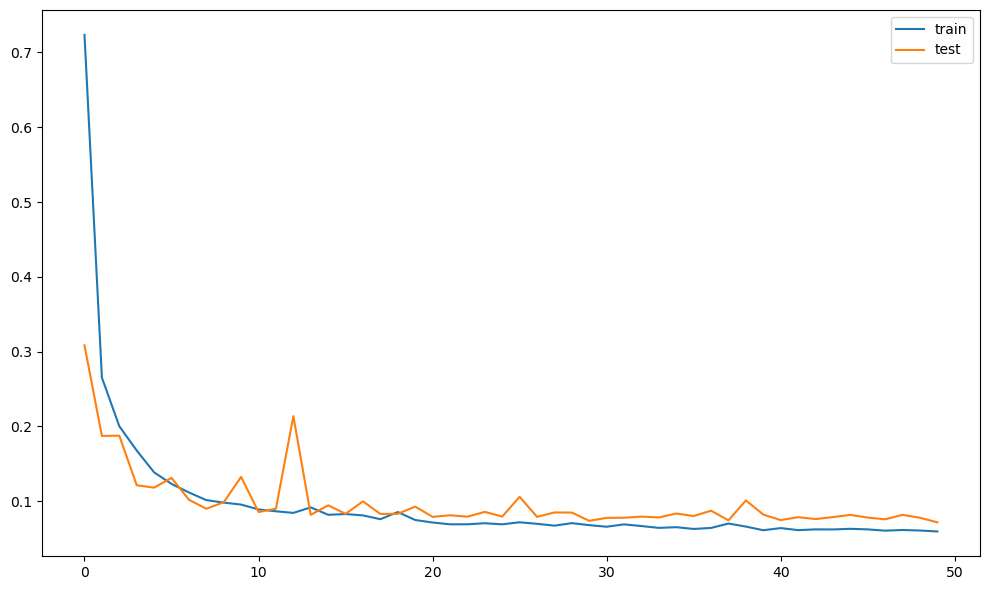

In [24]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

The loss values of the training and validation (~0.06) are comparablr to machine learning algorithms in Notebook1. This shows that neural networks are not always better than traditional machine learning algorithms. 

**5. Finalize Model**

In [25]:
# a) Predictions on validation dataset
y_pred = model.predict(X_val)

3179/3179 [==============================] - 8s 2ms/step


In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. The resulting mean absolute error indicates that the prediction performance of the Keras Sequential neural network is similar to that of the Linear Regression model.

In [26]:
# Calculate mean_absolute_error of the prediction
y_pred_trans = y_pred**2 # Convert y_pred back to original data format
mae_pred = mean_absolute_error(y_val, y_pred_trans)
print("Mean Absolute Error of predicted data: ", mae_pred)

Mean Absolute Error of predicted data:  1559.0781897431011


In [27]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_LSTM_model.sav'
dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://07834bd2-b821-4ecf-8fba-f036cc45961a/assets


**6. Conclusions**

- Staring with the problem statement, I performed an exploratory data analysis and cleaning process, transformed the data into a 3D format suitable for LSTM modeling, and made the target data stationary through root-squared data transformation techniques.

- The results from the loss values and mean absolute error suggest that neural networks are not always better than traditional machine learning algorithms. It is overkill for this particular problem where traditional algorithms such as linear regression or decision trees are more appropriate.

- Given expensive computational cost, it is more practical and effective to utilize machine learning algorithms to model this dataset.